In [244]:
#options(repr.plot.width= 5, repr.plot.height=14, warn = -1)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(psych))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(PerformanceAnalytics))
suppressPackageStartupMessages(library(foreach))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(AER))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(rstatix))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggcorrplot))
suppressPackageStartupMessages(library(data.table))

# Group 2 Project Proposal: Modelling the DoctorVisits dataset

# Introduction 

Predicting the number of visits made to a doctor based on general patient demographics has tremendous significance for identifying any factors that may hinder seeking medical attention. Thus, it is imperative to 1) identify important variables that can effectively predict the number of visits and 2) build a correctly specified prediction model. In this proposal, we discuss how we aim to accomplish these steps and build a well-specified prediction model for the number of doctor visits. 

## Dataset Overview

For our project we use the *DoctorVisits* dataset sourced from the AER package. This dataset was collected for a cross-sectional study through the Australian Health Survey in 1977-1978. Our response variable of interest is the number of doctor visits in past 2 weeks (visits). This is a variable of counts, ranging from 0-9 visits. It consists of 5190 observations on 11 variables, which were thought to influence the number of visits paid to a doctor. The 11 variables are as follows:

- gender: Factor indicating gender (categorical: female/male)
- age: Age in years divided by 100 (numeric)
- income: Annual income in tens of thousands of dollars (numeric)
- illness: Number of illnesses in past 2 weeks (numeric)
- reduced: Number of days of reduced activity in past 2 weeks due to illness or injury (numeric)
- health: General health questionnaire score using Goldberg's method (numeric)
- private: Does the individual have private health insurance? (categorical: yes/no)
- freepoor: Does the individual have free government health insurance due to low income (categorical: yes/no)
- freerepat: Does the individual have free government health insurance due to old age, disability or veteran status? (categorical: yes/no)
- nchronic: Is there a chronic condition not limiting activity? (categorical: yes/no)
- lchronic: Is there a chronic condition limiting activity? (categorical: yes/no)



## Exploratory Data Analysis

In our exploratory data analysis, we are interested in exploring: 

- The observed distribution of our response variable
- Whether any of the covariates appear to have an evident relationship with the response variable
- Whether any of the covariates are highly correlated with each other 
- Potential overdispersion
- Any other evident patterns/trends unique to the dataset

The first 6 rows of the DoctorVisits dataset look as follows: 

In [250]:
data("DoctorVisits")
full.data <- get("DoctorVisits")
head(full.data)

,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no
6,1,female,0.19,0.35,5,1,9,no,no,no,yes,no


## Exploring the response variable

The observed distribution of our response variable is as follows: 

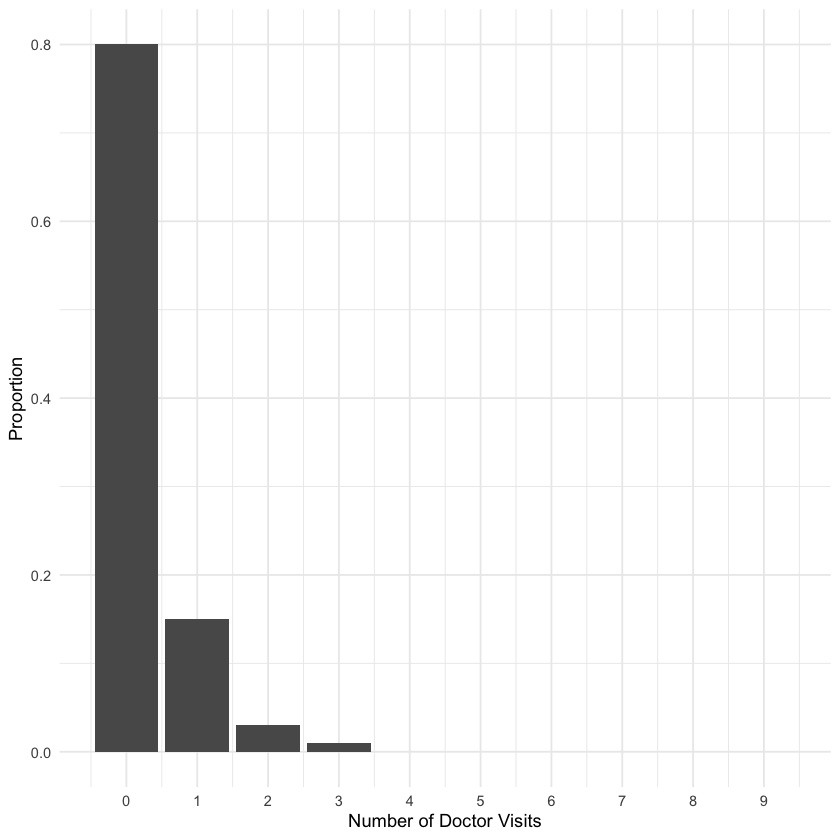

In [239]:
length <- nrow(full.data)
plot.data <- full.data %>%
    group_by(visits) %>%
    summarise(n = n()) %>%
    mutate(proportion = round(n/length,2))
plot.data %>%
  ggplot(aes(x= visits, y = proportion)) +
    geom_bar(stat = "identity") + 
    theme_minimal() +
    scale_x_continuous(breaks= pretty_breaks(n=9)) + 
  labs(x = "Number of Doctor Visits", y = "Proportion")

We see that our response variable follows a heavily skewed distribution. It is zero-inflated with 80% of the observations being zero values. 

## Summary statistics: exploring missing values and overdispersion

In [240]:
# Summary statistics 
get_summary_stats(full.data) 

variable,n,min,max,median,q1,q3,iqr,mad,mean,sd,se,ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,5190,0.19,0.72,0.32,0.22,0.62,0.40,0.193,0.406,0.205,0.003,0.006
health,5190,0.00,12.00,0.00,0.00,2.00,2.00,0.000,1.218,2.124,0.029,0.058
illness,5190,0.00,5.00,1.00,0.00,2.00,2.00,1.483,1.432,1.384,0.019,0.038
income,5190,0.00,1.50,0.55,0.25,0.90,0.65,0.445,0.583,0.369,0.005,0.010
reduced,5190,0.00,14.00,0.00,0.00,0.00,0.00,0.000,0.862,2.888,0.040,0.079
visits,5190,0.00,9.00,0.00,0.00,0.00,0.00,0.000,0.302,0.798,0.011,0.022


From the following summary statistics table (column n), we see that none of the variables have any missing observations. 

Looking at the visits variable, we see that while the mean is 0.302, the variance is $0.798^2$ which is 0.637. The variance is marginally higher than the mean here, indicating that there may be some potential overdispersion. 

## Exploring the association of the categorical variables with the Number of Doctor Visits

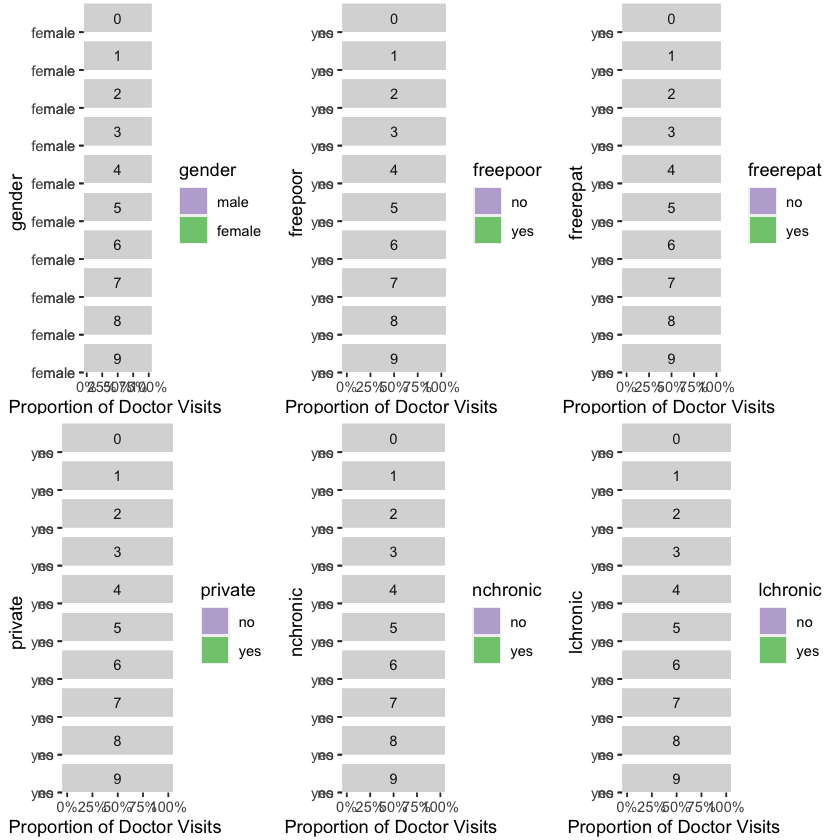

In [241]:
# Function for plot
full.data$y <- as.factor(full.data$visits)
prop_factor <- function (factor){
  full.data %>%
  count({{factor}}, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = {{factor}}, y = proportion, fill = {{factor}})) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))
}
# Plots for all categorical variables 
p1 <- prop_factor(gender)
p2 <- prop_factor(freepoor)
p3 <- prop_factor(freerepat)
p4 <- prop_factor(private)
p5 <- prop_factor(nchronic)
p6 <- prop_factor(lchronic)

grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 2, ncol = 3)

From these plots, gender may influence the number of visits, as compared to males, a greater proportion of females seem to make a higher number of visits. 
The variables freepoor and private do not seem to have any clear relationship with the proportion of doctor visits. We do see some indications 
that the freerepat variable may be important, as having the special old age insurance does seem to lead to visiting the doctor an increased number of times. 
Having a chronic condition, whether it limits (lchronic) or does not limit (nchronic) activity both seem 
to be an important variables, as the number of doctor visits seems to comparatively increase with both the nchronic and 
lchronic variable. 

In general, the proportions decrease as the number of visits increase for all the variables. In particular, at the highest count (9), a large proportion of the patients are male, have free special insurance (freerepat), and have chronic conditions, and such, these categorical variables are likely important for predicting these larger counts 

## Exploring the associations of the continuous variables with the number of Doctor Visits

Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”
Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”


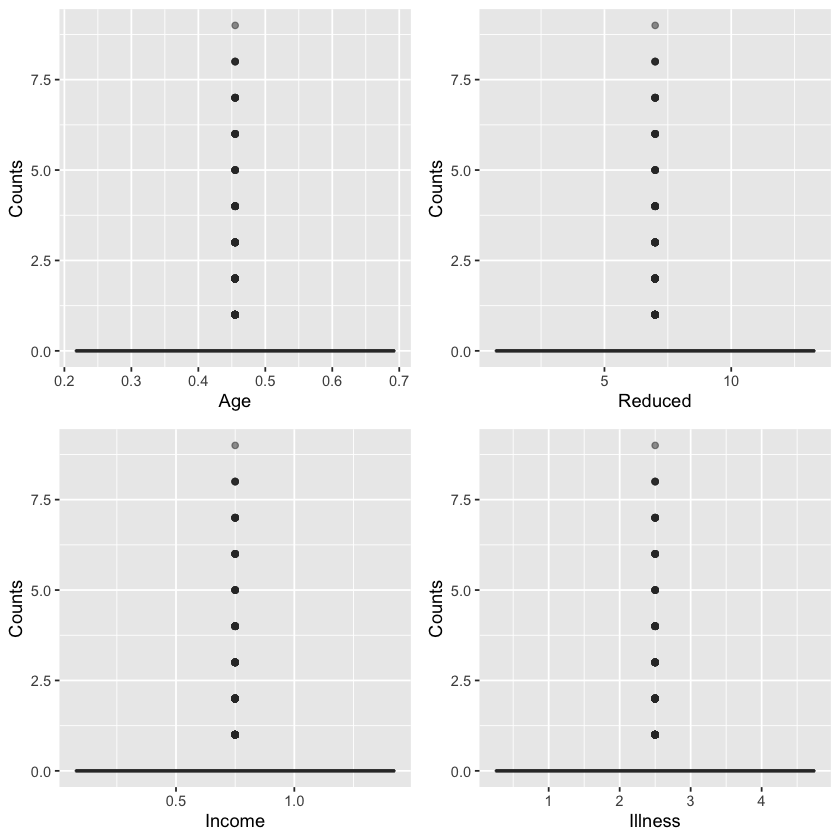

In [242]:
# Converting to factor for plot
full.data$visits1 <- factor(full.data$visits)

p5 <- ggplot(full.data, aes(age, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Age", y = "Counts")
p6 <- ggplot(full.data, aes(reduced, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Reduced", y = "Counts")
p7 <- ggplot(full.data, aes(income, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Income", y = "Counts")
p8 <- ggplot(full.data, aes(illness, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5)  + 
  labs(x = "Illness", y = "Counts")

ggarrange(p5, p6, p7, p8, nrow = 2, ncol = 2, common.legend = TRUE, legend="right")

Age is likely an important explanatory variable, there does seem to be a somewhat of an increasing number of doctor visits with increasing age (although this is hard to tell for some of the counts in the middle). In the boxplots for the reduced variable, we almost see an increasing trend between the number of visits and number of reduced days as well, which we expect. However, a clear trend is not evident due to the excess zeroes, which emphasizes the need for a zero-inflated model.  This trend holds true for the Illness variable as well, where the mean number of illnesses seems to increase along with higher doctor visits. There is no clear relationship between the number of visits and income, as income does not necessarily appear to increase or decrease for higher number of visits.  

## Relationships between the covariates

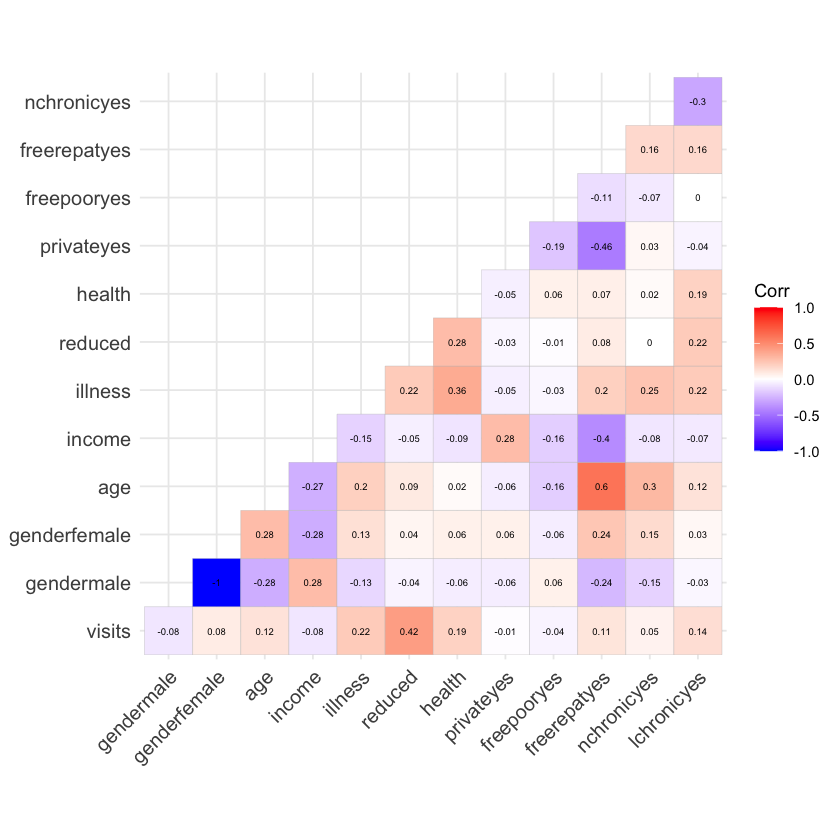

In [246]:
model.matrix(~0+., data = full.data) %>% 
  cor(use="pairwise.complete.obs") %>% 
  ggcorrplot(show.diag = F, type="lower", lab=TRUE, lab_size=2)

In [251]:
full.data<-full.data%>%
 mutate(gender=if_else(gender=="male",0,1))%>%
 mutate(private=if_else(private=="no",0,1))%>%
 mutate(freepoor=if_else(freepoor=="no",0,1))%>%
 mutate(freerepat=if_else(freerepat=="no",0,1))%>%
 mutate(nchronic=if_else(nchronic=="no",0,1))%>%
 mutate(lchronic=if_else(lchronic=="no",0,1))

### Tetrachoric correlations

In [252]:
is_binary <- function(x) all(unique(x) %in% c(0, 1))
binary_matrix <- full.data %>%
    select_if(is_binary)
tetrachr_matrix <- binary_matrix %>%
    mutate_all(as.factor) 
tetrachr_matrix <- data.matrix(tetrachr_matrix)
tetrachoric(tetrachr_matrix)

Warning message in cor.smooth(mat):
“Matrix was not positive definite, smoothing was done”


Call: tetrachoric(x = tetrachr_matrix)
tetrachoric correlation 
          gendr privt frepr frrpt nchrn lchrn
gender     1.00                              
private    0.04  1.00                        
freepoor  -0.19 -0.51  1.00                  
freerepat  0.33 -0.58 -0.39  1.00            
nchronic   0.25  0.01 -0.22  0.21  1.00      
lchronic   0.07 -0.13 -0.04  0.24 -0.86  1.00

 with tau of 
   gender   private  freepoor freerepat  nchronic  lchronic 
   -0.052     0.144     1.719     0.806     0.245     1.192 

### Point-biserial correlations

In [257]:
numeric_matrix <- full.data %>%
    select_if(Negate(is_binary))
biserial_matrix <- matrix(, nrow = ncol(binary_matrix), ncol = ncol(numeric_matrix))
for(i in 1:ncol(numeric_matrix)){
    for(j in 1:ncol(binary_matrix)){
        biserial_matrix[i,j]<-(biserial(numeric_matrix[,i],binary_matrix[,j])[1])
    }
}
colnames(biserial_matrix) <- colnames(numeric_matrix)
rownames(biserial_matrix) <- colnames(binary_matrix)
biserial_matrix

,visits,age,income,illness,reduced,health
gender,0.09859467,-0.01001824,-0.08486371,0.15052647,0.05723115,0.2247443
private,0.35248907,-0.07183308,-0.35921923,0.85450149,0.37491755,0.1982161
freepoor,-0.34680962,0.34921264,-0.35906494,-0.56870754,-0.09860119,-0.1072188
freerepat,0.16903043,-0.05877257,-0.05798474,0.28562785,0.31079320,0.3612876
nchronic,0.05146346,-0.03760711,-0.01490944,0.11840557,-0.00258372,0.3546257
lchronic,0.07199274,-0.06338002,0.12830592,0.09645898,0.02809813,0.3130459


In terms of relationships between the variables, we see that visits is moderately correlated with reduced, which further emphasizes its likely importance as an explanatory variable. There do not seem to be any particularly strong relationships between covariates with the exception of age, and having specialized old age insurance (freerepat) which is expected.

## Methods: Plan

The main question we hope to answer with this project is: 

##### Can the number of doctor visits be predicted using demographic variables, insurance status measures and chronic conditions of a patient?

We hope to build a prediction model using a generalized linear model framework. Some methodological questions we hope to answer in building our prediction model are as follows: 

1. For this dataset, does using a negative binomial model compared to a Poisson provide a better fit by accounting for overdispersion?
2. How does a zero-inflated model compare to a regular Poisson model?
3. Are different variables selected when an elastic net penality is used is compared to SCAD penalty?

## Data Preparation 

For the purpose of prediction and for performing variable selection (mentioned below), we divide our data into an 80/20 split. 80% of the data will thus be used to train the model, which includes performing variable selection. The other 20% will be used to test the performance of our model. 

## Variable selection 

Our exploratory analyses indicate that age, reduced, gender, Illness, freerepat, lchronic and nchronic seem to be important explanatory variables that show some relationship with the number of visits. However, with 9 categories of counts for our response and 11 covariates, data exploration is complicated. In particular, it is hard to see clear indications of which variables may be relatively more important in predicting the number of visits. Additionally, from our correlation matrix, we do see some moderately strong correlations, such as between age and freerepat yes for instance, which both appear to be important explanatory variables. For this reason, we plan to run penalized regression models to perform variable selection. During this process, we additionally plan to take into account the differences that may arise through using different penalties by comparing both the elastic net and SCAD penalties. The mpath R package will be used to fit these models. 

## Generalized Linear Model 

As our response data is composed of counts, the number of doctor visits can be modeled assuming a Poisson error distribution. 

### Overdispersion

A common issue in modeling such count data is overdispersion, where the variance of the response is much higher than expected by the data generation process. In our exploratory analysis, we saw potential indications of overdispersion, as the variance of the number of doctor counts was marginally higher than the mean. To address this issue, we will be supplementing our Poisson model with a negative binomial model and comparing fit. The dispersion that the negative binomial model estimates will allow us to understand if overdispersion is present. 

### Zero-inflation

As evident in our exploratory analysis, 80% of our response observations are zeroes. Thus, our data is zero-inflated, for which just a Poisson model is not sufficient. Therefore, we will employ the use of a zero-inflated model. In particular, our final model is likely to be a zero-inflated negative binomial, as this can simultaneously account for both overdispersion and the additional zeroes. 

### Model diagnostics 

We hope to evaluate the predictive ability of our model using metrics such as the mean squared error, the ROC curves, and diagnostic visualizations (residual vs fitted plots).

With our results, we hope to build a prediction model that is capable of predicting the number of doctor visits well, which has tremendous significance for identifying any factors that may hinder seeking medical attention. We additionally hope to contribute to the understanding of the differences in results arising from the use of two different regularization penalties for this dataset. 

## References 

Wang, Z., Ma, S., & Wang, C. Y. (2015). Variable selection for zero-inflated and overdispersed data with application to health care demand in Germany. Biometrical journal. Biometrische Zeitschrift, 57(5), 867–884. https://doi.org/10.1002/bimj.201400143

Cameron, A.C. and Trivedi, P.K. (1986). Econometric Models Based on Count Data: Comparisons and Applications of Some Estimators and Tests. Journal of Applied Econometrics, 1, 29–53.

Cameron, A.C. and Trivedi, P.K. (1998). Regression Analysis of Count Data. Cambridge: Cambridge University Press.

Mullahy, J. (1997). Heterogeneity, Excess Zeros, and the Structure of Count Data Models. Journal of Applied Econometrics, 12, 337–350.
